# Unzip the files

ONLY IF THE DATABASE IS UNDER ZIP FORMAT:

Having the files in ZIP format from the database source, here is a function to unzip these files.

In [ ]:
import os
import zipfile
from matplotlib import pyplot

In [ ]:
drive_path = '/content/drive/MyDrive/Projet Python - Valentin TASSEL Ariel TEDGUI'
path_to_zip_file = '{}/YearPredictionMSD.txt.zip'.format(drive_path)
directory_to_extract_to = '{}/'.format(drive_path)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Importation 




In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pandas
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import auc as auc_score
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from keras.models import load_model
from sklearn.externals import joblib
import pickle

# Dataframe definition

Let's retrieve the database and transform it into a python dataframe type.
<br>Let's define the features following this indication :

*   90 attributes, 12 = timbre average, 78 = timbre covariance
* The first value is the year (target), ranging from 1922 to 2011.
* Features extracted from the 'timbre' features from The Echo Nest API.
* We take the average and covariance over all 'segments', each segment
being described by a 12-dimensional timbre vector.



In [39]:
drive_path = '/content/drive/MyDrive/Projet Python - Valentin TASSEL Ariel TEDGUI'
#Read the txt file
df_YearPredictionMSD = pd.read_csv('{}/YearPredictionMSD.txt'.format(drive_path))

#Define columns
timbre_average_list = ['timbre average {}'.format(x) for x in range(0,12)]
timbre_covariance_list = ['timbre covariance {}'.format(x) for x in range(0,78)]

df_YearPredictionMSD.columns = [x for x in ['date']+timbre_average_list+timbre_covariance_list]


Let's visualize the dataframe

In [40]:
df_YearPredictionMSD

,date,timbre average 0,timbre average 1,timbre average 2,timbre average 3,timbre average 4,timbre average 5,timbre average 6,timbre average 7,timbre average 8,timbre average 9,timbre average 10,timbre average 11,timbre covariance 0,timbre covariance 1,timbre covariance 2,timbre covariance 3,timbre covariance 4,timbre covariance 5,timbre covariance 6,timbre covariance 7,timbre covariance 8,timbre covariance 9,timbre covariance 10,timbre covariance 11,timbre covariance 12,timbre covariance 13,timbre covariance 14,timbre covariance 15,timbre covariance 16,timbre covariance 17,timbre covariance 18,timbre covariance 19,timbre covariance 20,timbre covariance 21,timbre covariance 22,timbre covariance 23,timbre covariance 24,timbre covariance 25,timbre covariance 26,...,timbre covariance 38,timbre covariance 39,timbre covariance 40,timbre covariance 41,timbre covariance 42,timbre covariance 43,timbre covariance 44,timbre covariance 45,timbre covariance 46,timbre covariance 47,timbre covariance 48,timbre covariance 49,timbre covariance 50,timbre covariance 51,timbre covariance 52,timbre covariance 53,timbre covariance 54,timbre covariance 55,timbre covariance 56,timbre covariance 57,timbre covariance 58,timbre covariance 59,timbre covariance 60,timbre covariance 61,timbre covariance 62,timbre covariance 63,timbre covariance 64,timbre covariance 65,timbre covariance 66,timbre covariance 67,timbre covariance 68,timbre covariance 69,timbre covariance 70,timbre covariance 71,timbre covariance 72,timbre covariance 73,timbre covariance 74,timbre covariance 75,timbre covariance 76,timbre covariance 77
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,4

# Missing values

We have to verify of the dataframe don't contains missing values before making the exploration and the model.

In [41]:
missing_val_count_by_column = (df_YearPredictionMSD.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


*No missing values in the dataframe*

# Separation training set and testing set

Typically to perform machine learning, we do the following :


1.   Training phase: you present your data from your "gold standard" and train your model, by pairing the input with the expected output.
2.   In order to estimate how well your model has been trained (that is dependent upon the size of your data, the value you would like to predict, input, etc) and to estimate model properties (mean error for numeric predictors, classification errors for classifiers, recall and precision for IR-models etc.)
3. Now, you apply your freshly-developed model to the real-world data and get the results. Since you usually don't have any reference value in this type of data (otherwise, why would you need your model?), you can only speculate about the quality of your model output using the results of your validation phase.



In [42]:
#Taking the label
labels = df_YearPredictionMSD['date']
features = df_YearPredictionMSD.drop('date', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)
print("y_val shape: ",y_val.shape)

y_train shape:  (309206,)
y_test shape:  (103069,)
y_val shape:  (103069,)


# Exploratory data analysis

## Analysing 'Year'

In [43]:
y_train.describe()

count    309206.000000
mean       1998.361604
std          10.957147
min        1922.000000
25%        1994.000000
50%        2002.000000
75%        2006.000000
max        2010.000000
Name: date, dtype: float64

*Very well... It seems that our minimum date is 1922. And the maximum is 2011.*

Text(0.5, 1.0, 'Samples')

<Figure size 2160x576 with 0 Axes>

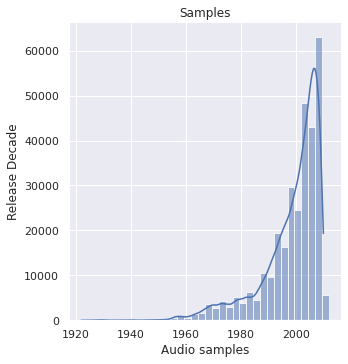

In [44]:
plt.figure(figsize=(30,8))
sns.displot(y_train,binwidth=2.5, kde=True)

plt.xlabel("Audio samples")
plt.ylabel("Release Decade")
plt.title("Samples")

*Looking at the distribution we observe :*


*   Deviate from the normal distribution
*   Show a negative skewness
*   Show peakedness



In [45]:
#Skewness and kurtosis
print("Skewness: %f" % df_YearPredictionMSD['date'].skew())
print("Kurtosis: %f" % df_YearPredictionMSD['date'].kurt())

Skewness: -1.731547
Kurtosis: 3.493787


## Construction of the new label Decade

In [46]:
def Date_to_decade(date):
  return (int(date/10))*10

y_train = y_train.apply(lambda x: Date_to_decade(x))
y_test = y_test.apply(lambda x: Date_to_decade(x))
y_val = y_val.apply(lambda x: Date_to_decade(x))

In [47]:
y_train.value_counts()

2000    178989
1990     74910
1980     25074
1970     15064
1960      7147
2010      5678
1950      1856
1940       219
1930       140
1920       129
Name: date, dtype: int64

Text(0.5, 1.0, 'Samples in the dataset/release decade')

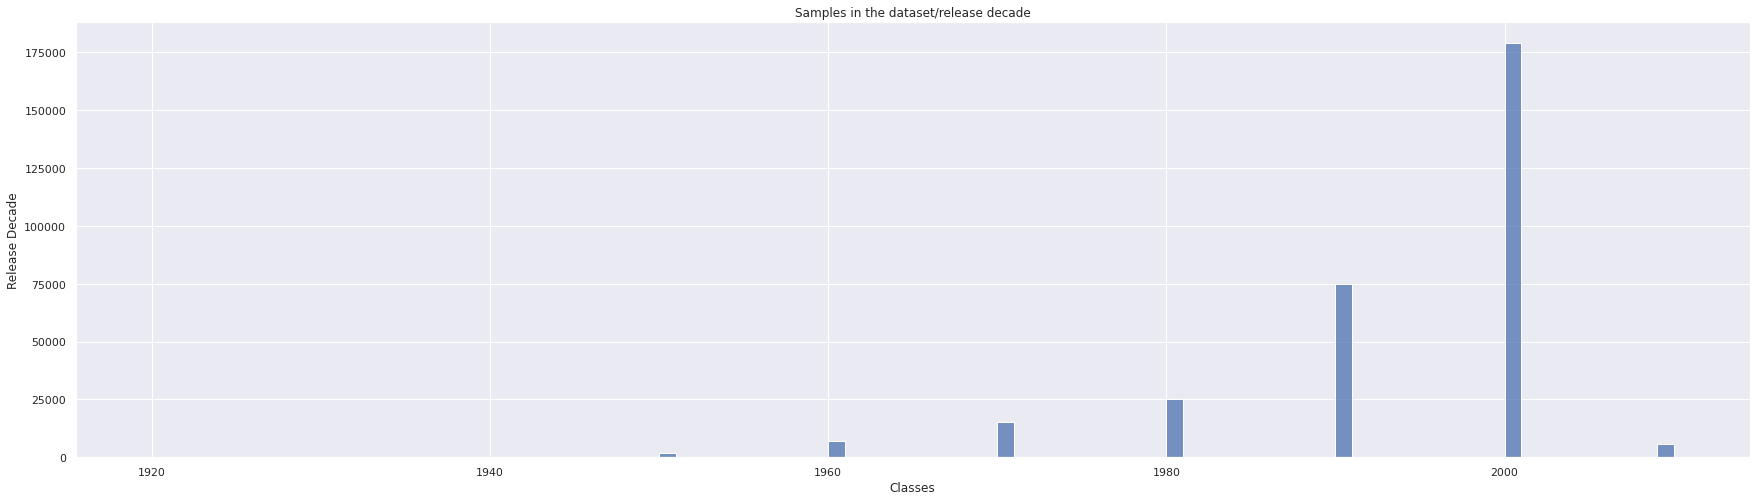

In [48]:
plt.figure(figsize=(30,8))
sns.histplot(y_train, binwidth=1)

plt.xlabel("Classes")
plt.ylabel("Release Decade")
plt.title("Samples in the dataset/release decade")

One of the common problems in Machine Learning is handling the multiclass imbalanced data. If we don't handle this problem then the model will be biaised in favor of the majority class.

## Relationship with timbre averages

Below the list of timbre average variable :

In [49]:
timbre_average_list

['timbre average 0',
 'timbre average 1',
 'timbre average 2',
 'timbre average 3',
 'timbre average 4',
 'timbre average 5',
 'timbre average 6',
 'timbre average 7',
 'timbre average 8',
 'timbre average 9',
 'timbre average 10',
 'timbre average 11']

In [50]:
#df timbre average
X_timbre_average = X_train[timbre_average_list]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Text(0.5, 1.0, 'Timbre average gaussian kernel density')

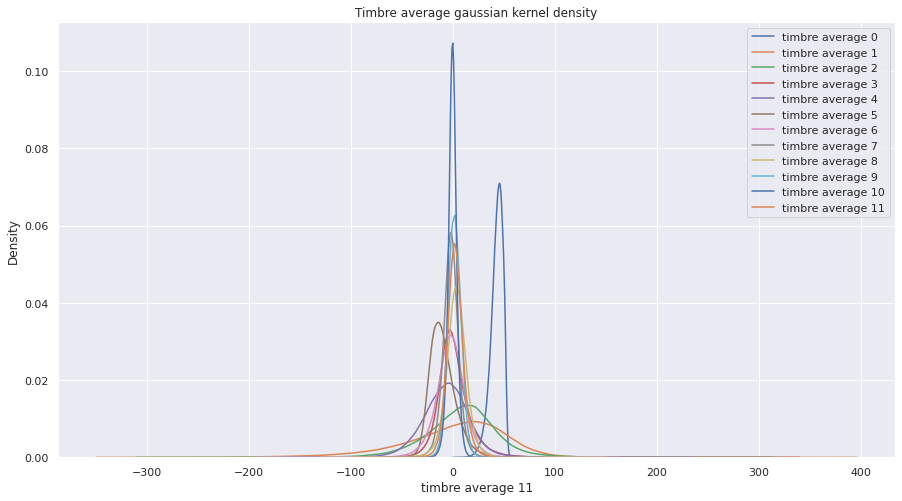

In [51]:
sns.set(rc={"figure.figsize": (15, 8)})
for x in X_timbre_average.columns:
  sns.distplot(X_train[x], label=x, hist=False)
plt.legend()
plt.title('Timbre average gaussian kernel density')

We have to standardize the features.

* **Standardization** is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

**Standardization** can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

In [52]:
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()


# apply standardization on numerical features
for i in timbre_average_list:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Text(0.5, 1.0, 'Timbre average gaussian kernel density after standardization')

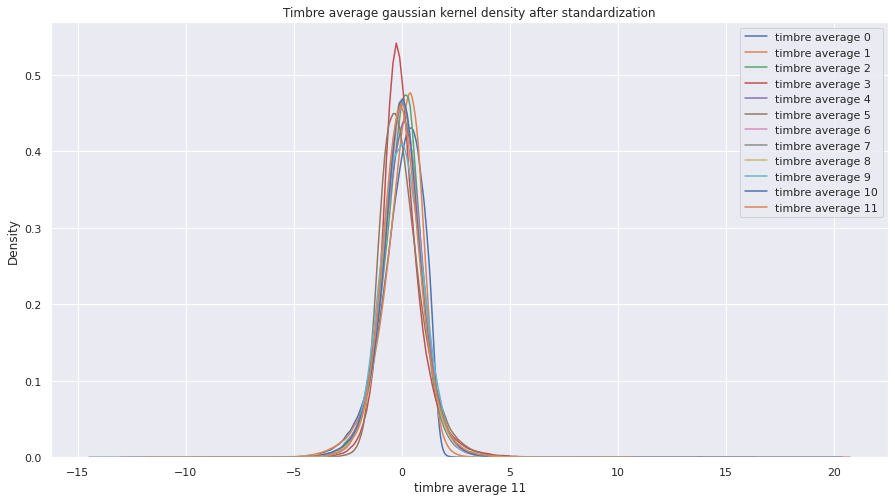

In [53]:
sns.set(rc={"figure.figsize": (15, 8)})
for x in X_timbre_average.columns:
  sns.distplot(X_train_stand[x], label=x, hist=False)
plt.legend()
plt.title('Timbre average gaussian kernel density after standardization')


In [54]:
def Standardization(dataset, column_list):
  dataset_stand = dataset.copy()

  for i in column_list:
    
    # fit on training data column
    scale = StandardScaler().fit(dataset_stand[[i]])
    
    # transform the training data column
    dataset_stand[i] = scale.transform(dataset_stand[[i]])

  return dataset_stand

In [55]:
X_train = Standardization(X_train, timbre_average_list)
X_test = Standardization(X_test, timbre_average_list)
X_val = Standardization(X_val, timbre_average_list)

In [56]:
X_train_test = StandardScaler().fit(X_train)


### Correlation matrix

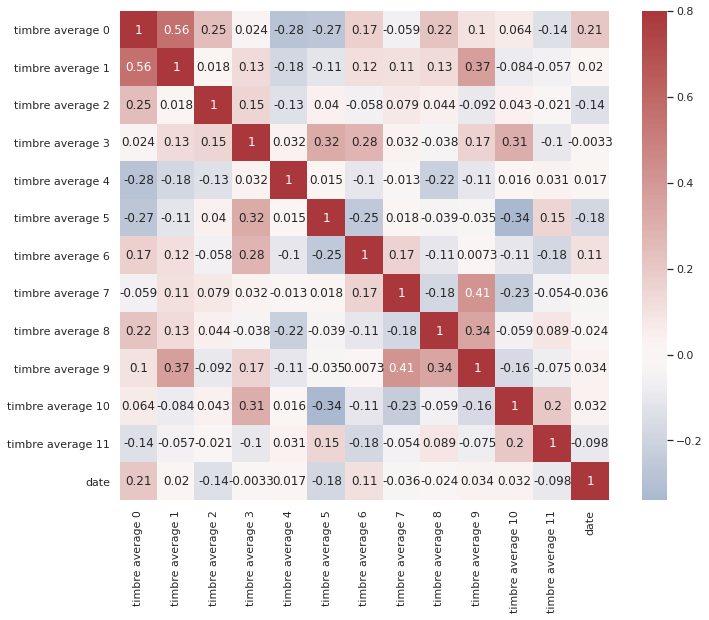

In [57]:
df_timbre_average = pd.concat([X_train[timbre_average_list], y_train], axis=1)
#correlation matrix
corrmat = df_timbre_average.corr()
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, vmax=.8, square=True, center =0, cmap="vlag", annot=True);

*We don't observe too much correlation between the date and the timbre averages.
Even between the timbre averages there are not too many correlation*

### Box plot between the 'year' and the timbre averages

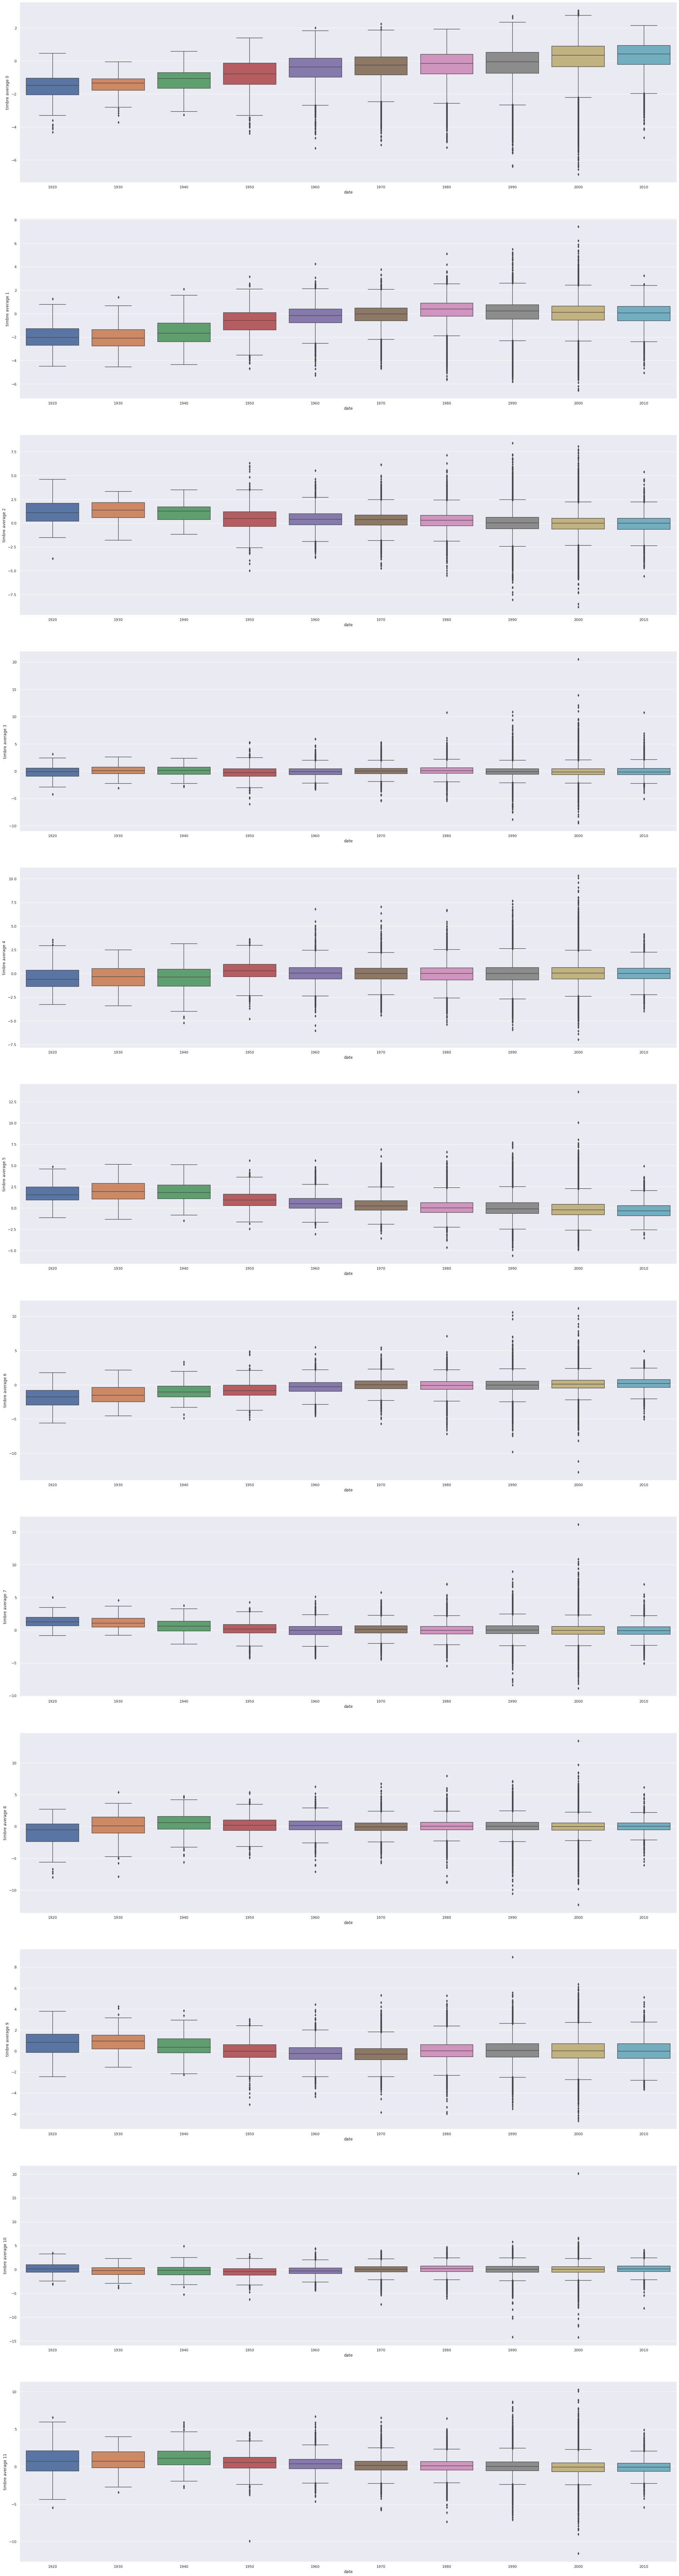

In [58]:
fig, axes = plt.subplots(len(timbre_average_list), figsize=(len(timbre_average_list)*3,len(timbre_average_list)*12))
for figid, timbre_col in zip(range(0,len(timbre_average_list)), timbre_average_list):
  ax = sns.boxplot(x="date", y=timbre_col, data=df_timbre_average, ax=axes[figid])

*We observe non linear relation between the timbre averages and the date*

*Only timbre average 1 seems to have its little correlation with the decade*

## Timbre covariances analysis

In [59]:
#df timbre covariances
df_timbre_covariance = pd.concat([X_train[timbre_covariance_list], y_train], axis=1)

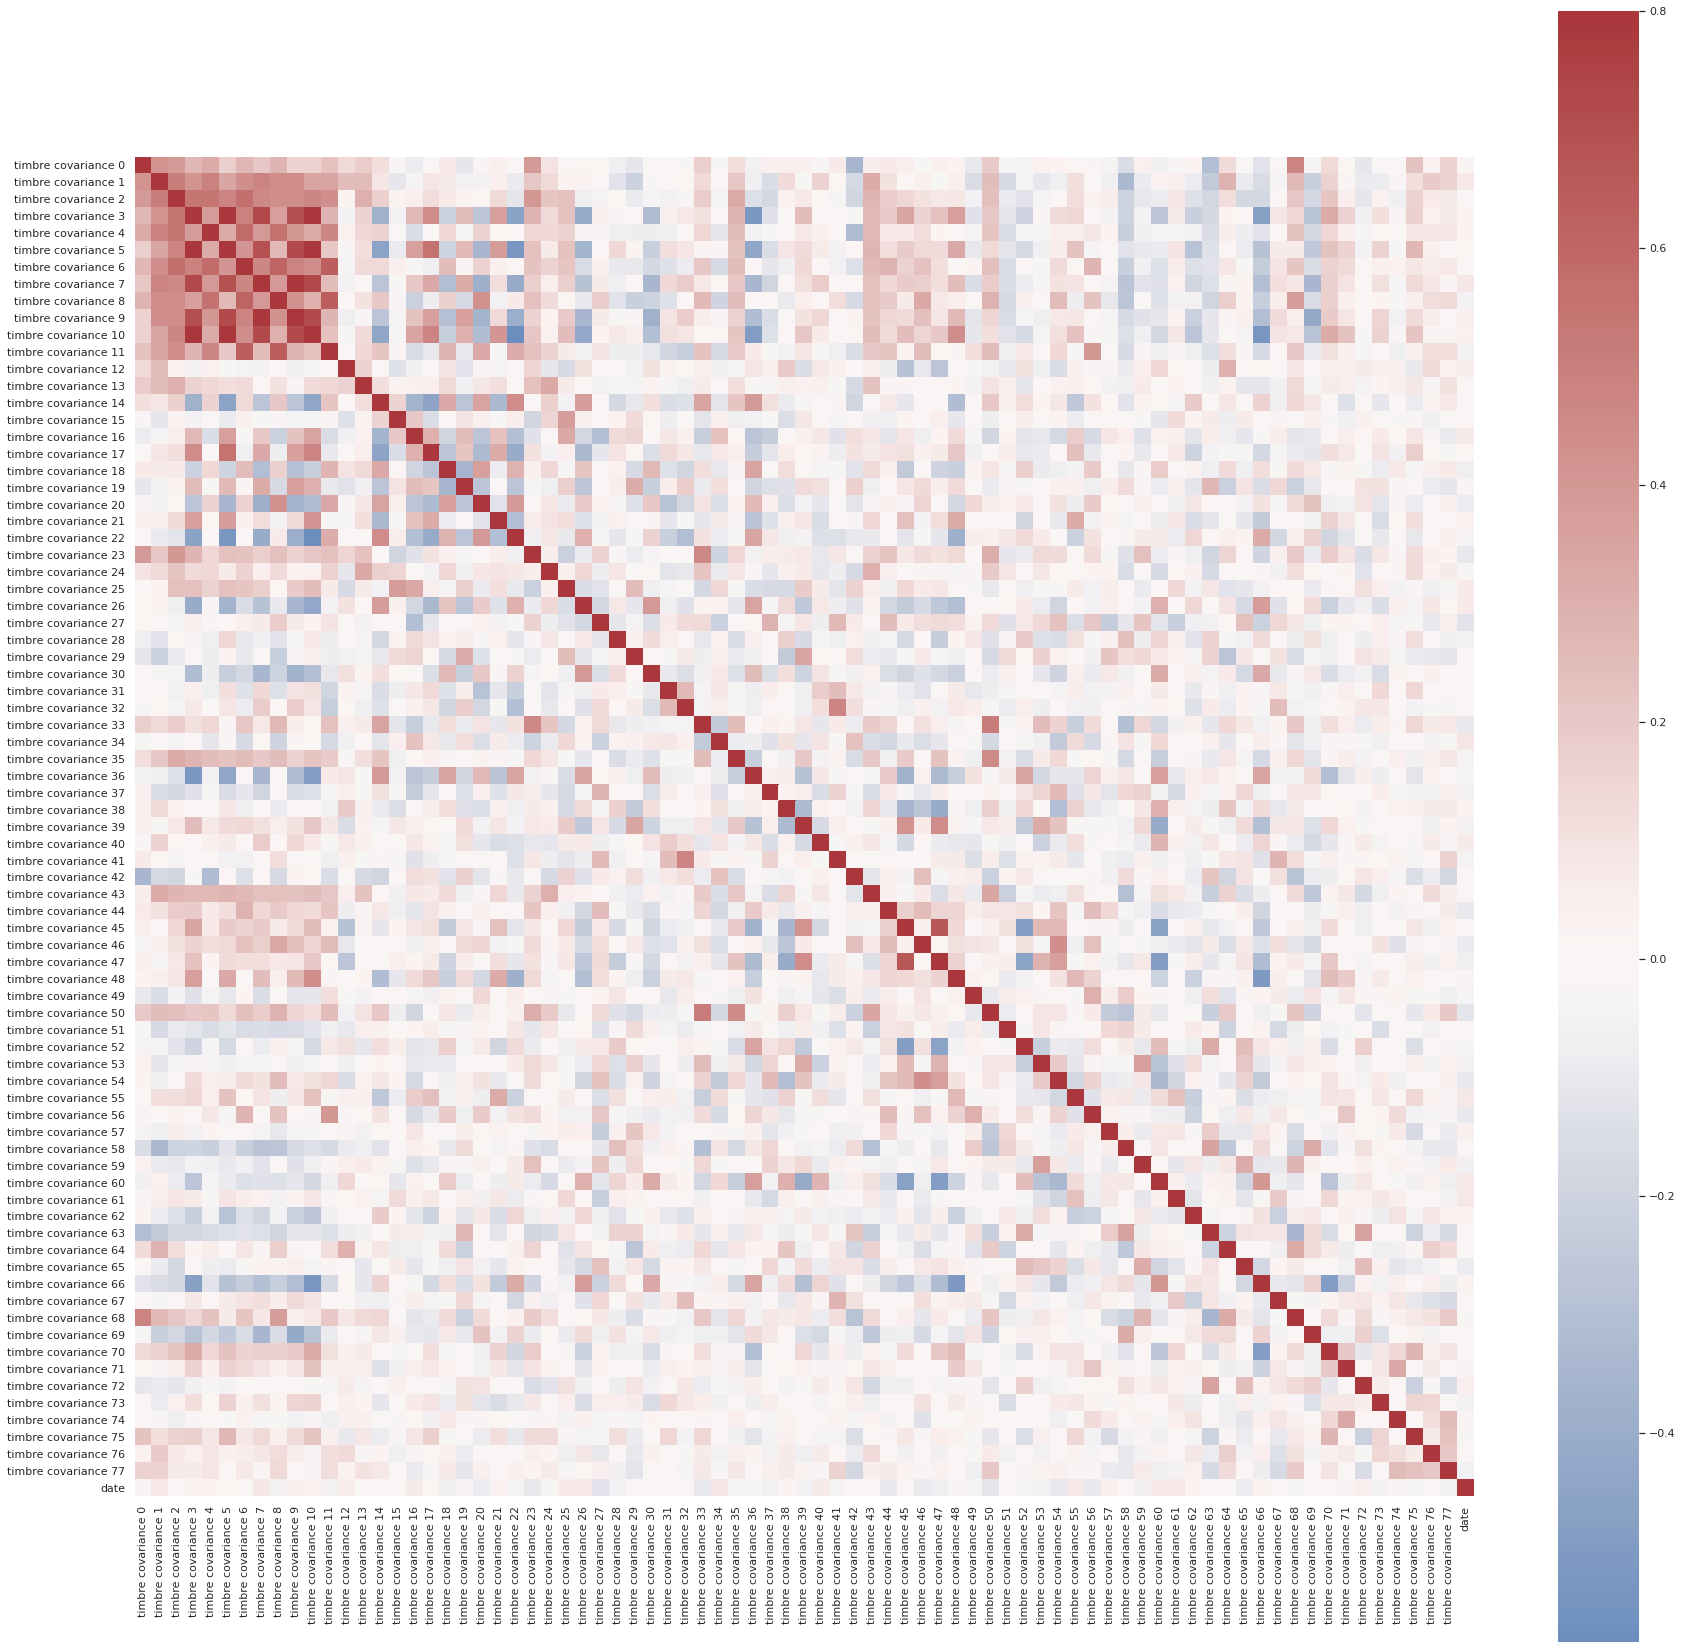

In [60]:
#correlation matrix
corrmat = df_timbre_covariance.corr()
f, ax = plt.subplots(figsize=(30, 30))

sns.heatmap(corrmat, vmax=.8, square=True, center =0, cmap="vlag");

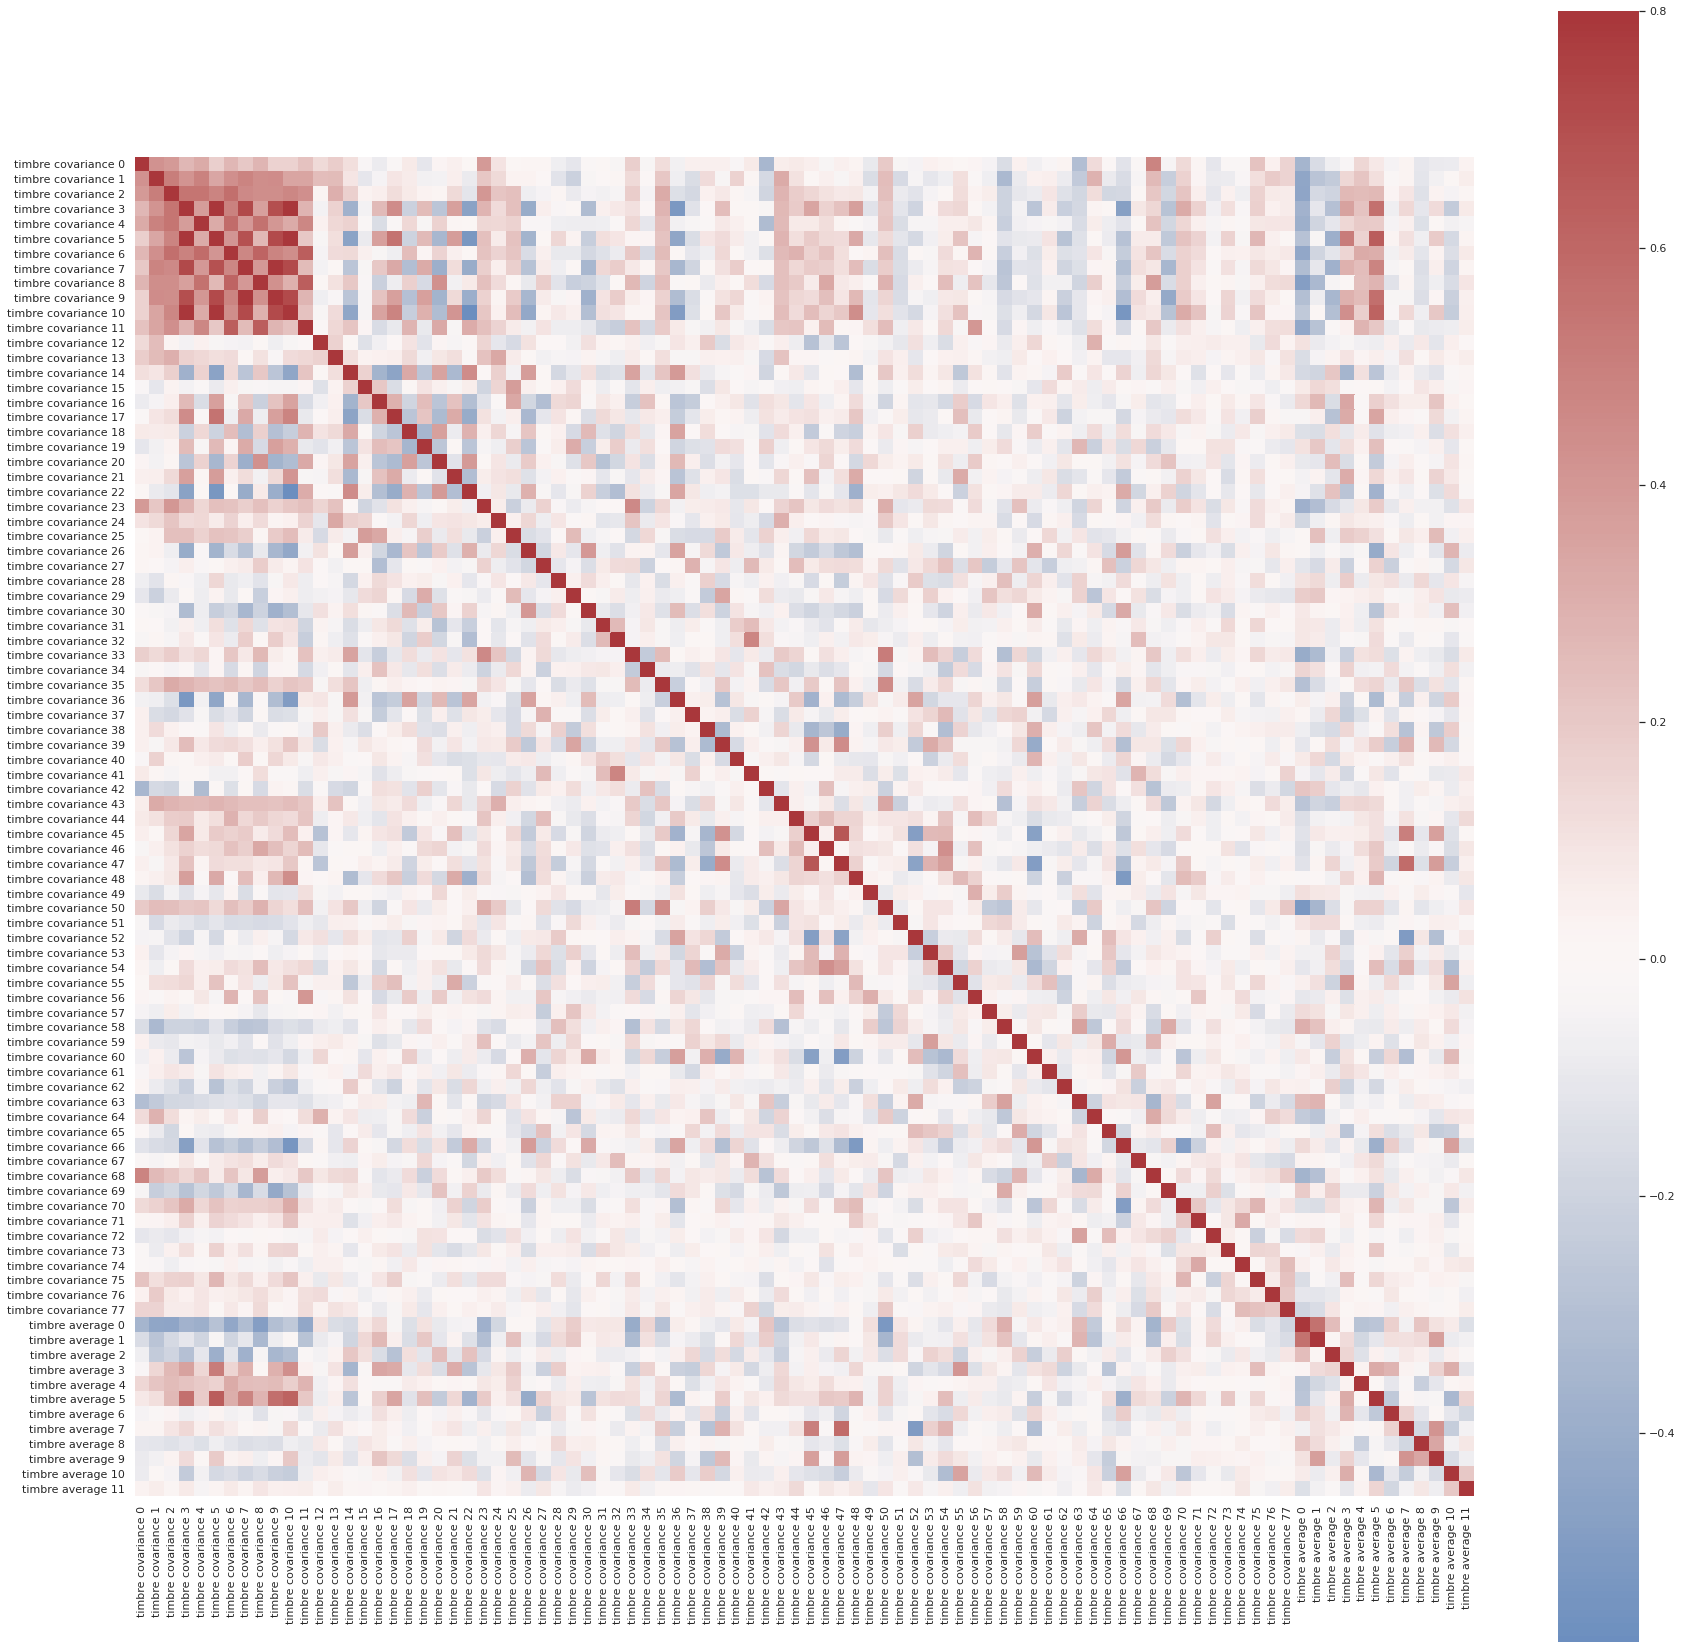

In [61]:
df_timbre = pd.concat([X_train[timbre_covariance_list], X_train[timbre_average_list]], axis=1)
#correlation matrix
corrmat = df_timbre.corr()
f, ax = plt.subplots(figsize=(30, 30))

sns.heatmap(corrmat, vmax=.8, square=True, center =0, cmap="vlag");

# Feature importance analysis

### Feature selection using chi2

Chi2 is a filter methods used to score the importance of the features, to select a subset of input features that are most predictive.

In [62]:
from sklearn import preprocessing
from sklearn.feature_selection import chi2
sc_range = preprocessing.MinMaxScaler()
features_range = sc_range.fit_transform(features)
f_score = chi2(features_range, labels)

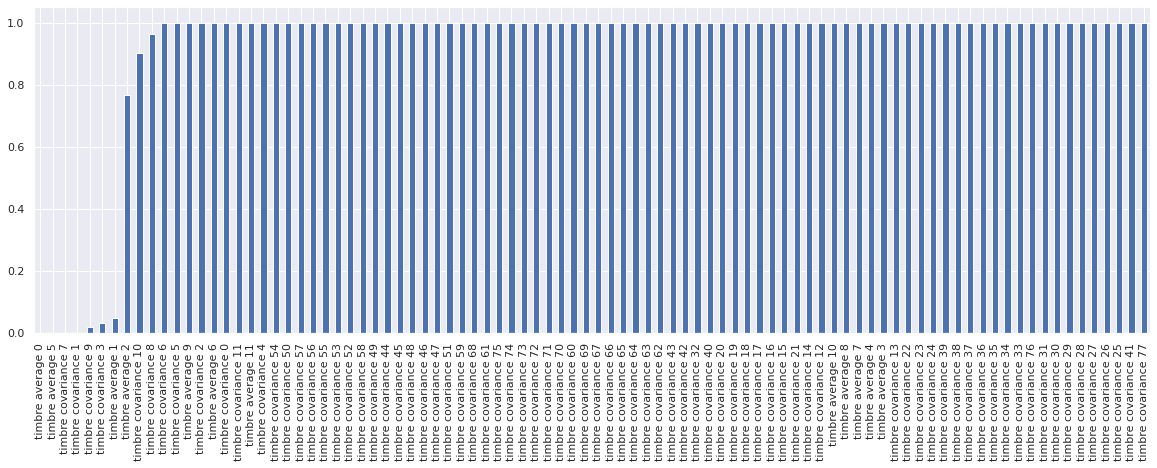

In [63]:
pvalues = pd.Series(f_score[1])
pvalues.index=features.columns
pvalues.sort_values(ascending=True).plot.bar(figsize=(20,6))

In [64]:
#sel_ = SelectKBest(chi2, k=3).fit(features_range, labels)
#features.columns[sel_.get_support()]

## Feature Selection using 

# Dimensionality reduction

Here we are in presence of a large quantity of variables, we want to reduce the dimensionality by projecting the data to a lower dimensional subspace which capture the essence of the data

The most standard linear method of supervised dimensionality reduction is called linear discriminant analysis (LDA). It is designed to find low-dimensional projection that maximizes class separation.

In [65]:
# evaluate lda with naive bayes algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

Test for 5 dimensions

In [66]:
# define the pipeline
steps = [('lda', LinearDiscriminantAnalysis(n_components=5)), ('m', GaussianNB())]
model = Pipeline(steps=steps)

In [67]:
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.604 (0.002)


How we know that reducing to 5 dimensions of input is good ?
We don't know.

So we will make function to find the optimal dimension reduction

>1 0.602 (0.001)
>2 0.601 (0.001)
>3 0.603 (0.001)
>4 0.604 (0.001)
>5 0.604 (0.001)
>6 0.604 (0.001)
>7 0.602 (0.002)
>8 0.606 (0.001)
>9 0.605 (0.002)


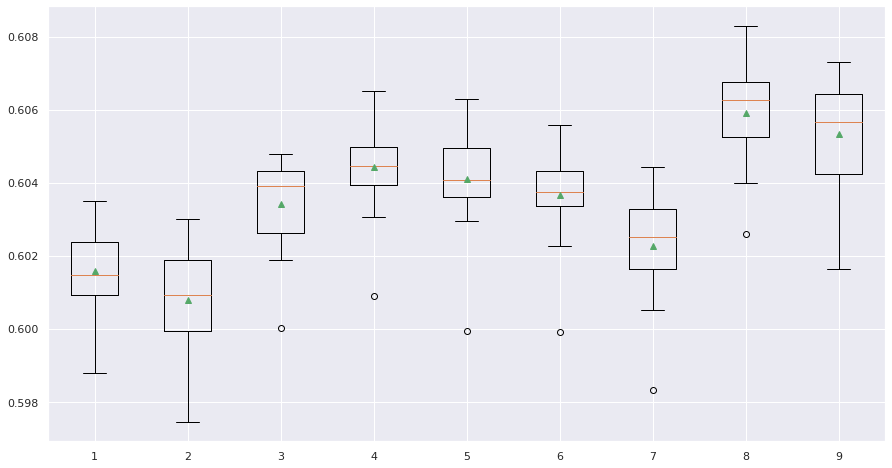

In [68]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

 
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,10):
		steps = [('lda', LinearDiscriminantAnalysis(n_components=i)), ('m', GaussianNB())]
		models[str(i)] = Pipeline(steps=steps)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [69]:
# make predictions using lda with naive bayes
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

lda = LinearDiscriminantAnalysis(n_components=8)
X_train_reduced = lda.fit_transform(X_train, y_train)
X_test_reduced = lda.transform(X_test)
X_val_reduced = lda.transform(X_val)

In [18]:
filename = 'lda_dim_reduction.joblib'
joblib.dump(lda, '{}/{}'.format(drive_path,filename))

['/content/drive/MyDrive/Projet Python - Valentin TASSEL Ariel TEDGUI/lda_dim_reduction.joblib']

# Models

Verification of the shapes of the train/test/val sets

In [70]:
X_train.shape

(309206, 90)

In [71]:
X_test.shape

(103069, 90)

In [72]:
X_val.shape

(103069, 90)

Verification of the shapes of the train_reduced/test_reduced/val_reduced sets

In [73]:
X_train_reduced.shape

(309206, 8)

In [74]:
X_test_reduced.shape

(103069, 8)

In [75]:
X_val_reduced.shape

(103069, 8)

Final dataframe for model benchmarking

In [113]:
df_benchmark = pd.DataFrame(columns=['Model name','Accuracy', 'Precision','Recall','F1 Score'])

In [114]:
df_benchmark.head()

,Model name,Accuracy,Precision,Recall,F1 Score


## K-NN as baseline model

Inputs:

* X_train_reduced
* y_train

### First model

We use K-NN default parameters with the reduced dataset to have the minimal time spended

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_default = KNeighborsClassifier()
knn_default.fit(X_train_reduced, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Result on the testset

In [ ]:
y_pred = knn_default.predict(X_test_reduced)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1920       0.16      0.17      0.16        48
        1930       0.24      0.16      0.19        57
        1940       0.09      0.07      0.08        67
        1950       0.13      0.09      0.11       650
        1960       0.14      0.11      0.12      2265
        1970       0.24      0.22      0.23      4835
        1980       0.32      0.29      0.30      8346
        1990       0.38      0.35      0.37     24953
        2000       0.72      0.79      0.75     59987
        2010       0.02      0.00      0.00      1861

    accuracy                           0.58    103069
   macro avg       0.24      0.22      0.23    103069
weighted avg       0.55      0.58      0.57    103069



### Hyperparameter tuning
Hyperparameter Tuning to improve the model performance

We regroup train and test for cross validation

In [ ]:
%%time
#List Hyperparameters that we want to tune.
n_neighbors = list(range(5,9))

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=3)
#Fit the model
best_model = clf.fit(X_train_reduced,y_train)
#Print The value of best Hyperparameters
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best n_neighbors: 8
CPU times: user 5min 56s, sys: 80.8 ms, total: 5min 56s
Wall time: 5min 57s


Run the best parameters algorithm

In [ ]:
knn_tuned = KNeighborsClassifier(p=2, n_neighbors=8)
knn_tuned.fit(X_train_reduced, y_train)

y_pred = knn_tuned.predict(X_test_reduced)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1920       0.19      0.10      0.13        48
        1930       0.40      0.04      0.06        57
        1940       0.14      0.04      0.07        67
        1950       0.17      0.06      0.09       650
        1960       0.17      0.10      0.13      2265
        1970       0.28      0.21      0.24      4835
        1980       0.37      0.28      0.32      8346
        1990       0.40      0.36      0.38     24953
        2000       0.71      0.82      0.77     59987
        2010       0.00      0.00      0.00      1861

    accuracy                           0.60    103069
   macro avg       0.28      0.20      0.22    103069
weighted avg       0.56      0.60      0.58    103069



Add to benchmark with the prediction of the validation set

In [ ]:
y_pred = knn_tuned.predict(X_val_reduced)
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

        1920       0.18      0.06      0.09        47
        1930       0.20      0.05      0.09        55
        1940       0.17      0.04      0.07        70
        1950       0.10      0.04      0.05       596
        1960       0.18      0.11      0.14      2327
        1970       0.28      0.21      0.24      4846
        1980       0.37      0.28      0.32      8394
        1990       0.40      0.36      0.38     24850
        2000       0.72      0.82      0.77     60026
        2010       0.25      0.00      0.00      1858

    accuracy                           0.60    103069
   macro avg       0.28      0.20      0.21    103069
weighted avg       0.57      0.60      0.58    103069



In [ ]:
metrics_result = [accuracy(y_val, y_pred),precision(y_val, y_pred, average= "macro"),recall(y_val, y_pred, average="macro"),f1_score(y_val, y_pred, average= "macro")]

In [ ]:
df_benchmark = df_benchmark.append({'Model name':'K-NN','Accuracy':metrics_result[0], 'Precision':metrics_result[1],
                     'Recall':metrics_result[2],'F1 Score':metrics_result[3]}, ignore_index=True)

In [ ]:
df_benchmark

,Model name,Accuracy,Precision,Recall,F1 Score
0,K-NN,0.600937,0.283826,0.19813,0.214031


### Saving 

In [ ]:


filename = 'knn_tuned.pkl'
joblib.dump(knn_tuned, '{}/{}'.format(drive_path,filename))

['/content/drive/MyDrive/Projet Python - Valentin TASSEL Ariel TEDGUI/knn_tuned.joblib']

## Random Forest GridSearch

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_default = RandomForestClassifier()
rf_default.fit(X_train_reduced, y_train)


CPU times: user 2min 7s, sys: 1.94 s, total: 2min 9s
Wall time: 2min 9s


In [ ]:
rf_default

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf_default.predict(X_test_reduced)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1920       0.00      0.00      0.00        48
        1930       1.00      0.05      0.10        57
        1940       0.50      0.01      0.03        67
        1950       0.46      0.01      0.02       650
        1960       0.31      0.03      0.06      2265
        1970       0.39      0.18      0.24      4835
        1980       0.47      0.23      0.31      8346
        1990       0.43      0.35      0.38     24953
        2000       0.70      0.89      0.78     59987
        2010       1.00      0.00      0.00      1861

    accuracy                           0.63    103069
   macro avg       0.53      0.18      0.19    103069
weighted avg       0.60      0.63      0.59    103069



### Hyperparameter tuning

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [100, 130, 150]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 12.3min finished


CPU times: user 3min 14s, sys: 2.56 s, total: 3min 17s
Wall time: 15min 33s


### Best estimator

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = grid_search.predict(X_test_reduced)

### Result

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1920       0.00      0.00      0.00        48
        1930       0.60      0.05      0.10        57
        1940       0.67      0.03      0.06        67
        1950       0.67      0.01      0.01       650
        1960       0.31      0.03      0.05      2265
        1970       0.38      0.17      0.24      4835
        1980       0.48      0.24      0.32      8346
        1990       0.43      0.35      0.39     24953
        2000       0.70      0.89      0.78     59987
        2010       1.00      0.00      0.00      1861

    accuracy                           0.63    103069
   macro avg       0.52      0.18      0.19    103069
weighted avg       0.60      0.63      0.59    103069



Add to benchmark with the prediction of the validation set

In [ ]:
y_pred = grid_search.predict(X_val_reduced)
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

        1920       1.00      0.04      0.08        47
        1930       0.00      0.00      0.00        55
        1940       0.00      0.00      0.00        70
        1950       0.50      0.01      0.01       596
        1960       0.31      0.04      0.06      2327
        1970       0.40      0.18      0.25      4846
        1980       0.47      0.24      0.32      8394
        1990       0.43      0.36      0.39     24850
        2000       0.70      0.89      0.79     60026
        2010       1.00      0.00      0.00      1858

    accuracy                           0.63    103069
   macro avg       0.48      0.18      0.19    103069
weighted avg       0.60      0.63      0.59    103069



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics_result = [accuracy(y_val, y_pred),precision(y_val, y_pred, average= "macro"),recall(y_val, y_pred, average="macro"),f1_score(y_val, y_pred, average= "macro")]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_benchmark = df_benchmark.append({'Model name':'Random Forest','Accuracy':metrics_result[0], 'Precision':metrics_result[1],
                     'Recall':metrics_result[2],'F1 Score':metrics_result[3]}, ignore_index=True)

In [ ]:
df_benchmark

,Model name,Accuracy,Precision,Recall,F1 Score
0,K-NN,0.600937,0.283826,0.198130,0.214031
1,Random Forest,0.631868,0.481588,0.175073,0.190031


### Save the model

In [ ]:
filename = 'random_forest.pkl'
joblib.dump(grid_search, '{}/{}'.format(drive_path,filename))

['/content/drive/MyDrive/Projet Python - Valentin TASSEL Ariel TEDGUI/random_forest.pkl']

In [ ]:
# save the model to disk
filename = 'random_forest_est150.sav'
pickle.dump(grid_search, open("{}/{}".format(drive_path, filename), 'wb'))


### Load the model 

In [ ]:
filename = 'random_forest_est100.sav'
loaded_model = pickle.load(open("{}/{}".format(drive_path, filename), 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6348271546245718


## XgBoost Classifier


In [ ]:
from xgboost import XGBClassifier

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_reduced, y_train)
print(model_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
y_pred = model_xgb.predict(X_test_reduced)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1920       0.00      0.00      0.00        48
        1930       0.00      0.00      0.00        57
        1940       0.00      0.00      0.00        67
        1950       0.00      0.00      0.00       650
        1960       0.39      0.01      0.03      2265
        1970       0.38      0.16      0.22      4835
        1980       0.47      0.22      0.30      8346
        1990       0.43      0.36      0.39     24953
        2000       0.70      0.89      0.79     59987
        2010       0.00      0.00      0.00      1861

    accuracy                           0.63    103069
   macro avg       0.24      0.16      0.17    103069
weighted avg       0.58      0.63      0.59    103069



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Hyperparameter tuning

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'eta': [0.01,0.1,0.3],
    'max_depth': [3,6,9]
}# Create a based model
xgb_tuning = XGBClassifier()# Instantiate the grid search model
grid_search_xgb = GridSearchCV(estimator = xgb_tuning, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search_xgb.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 131.0min finished


CPU times: user 9min 3s, sys: 522 ms, total: 9min 3s
Wall time: 2h 20min 4s


### Best estimator

In [ ]:
grid_search_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = grid_search_xgb.predict(X_test_reduced)

### Result

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1920       0.00      0.00      0.00        48
        1930       0.50      0.04      0.07        57
        1940       0.40      0.03      0.06        67
        1950       0.33      0.00      0.00       650
        1960       0.33      0.02      0.04      2265
        1970       0.39      0.18      0.24      4835
        1980       0.48      0.24      0.32      8346
        1990       0.44      0.36      0.39     24953
        2000       0.70      0.89      0.79     59987
        2010       0.00      0.00      0.00      1861

    accuracy                           0.63    103069
   macro avg       0.36      0.18      0.19    103069
weighted avg       0.58      0.63      0.59    103069



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Add to benchmark with the prediction of the validation set

In [ ]:
y_pred = grid_search_xgb.predict(X_val_reduced)
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

        1920       0.30      0.06      0.11        47
        1930       0.00      0.00      0.00        55
        1940       0.33      0.01      0.03        70
        1950       1.00      0.00      0.00       596
        1960       0.34      0.02      0.04      2327
        1970       0.38      0.18      0.24      4846
        1980       0.48      0.25      0.33      8394
        1990       0.43      0.37      0.40     24850
        2000       0.71      0.89      0.79     60026
        2010       0.00      0.00      0.00      1858

    accuracy                           0.63    103069
   macro avg       0.40      0.18      0.19    103069
weighted avg       0.59      0.63      0.59    103069



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics_result = [accuracy(y_val, y_pred),precision(y_val, y_pred, average= "macro"),recall(y_val, y_pred, average="macro"),f1_score(y_val, y_pred, average= "macro")]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_benchmark = df_benchmark.append({'Model name':'XGB Classifier','Accuracy':metrics_result[0], 'Precision':metrics_result[1],
                     'Recall':metrics_result[2],'F1 Score':metrics_result[3]}, ignore_index=True)

In [ ]:
df_benchmark

,Model name,Accuracy,Precision,Recall,F1 Score
0,XGB Classifier,0.634109,0.398034,0.178039,0.192986


### Save the model

In [ ]:
filename = 'xgb_classifier.pkl'
joblib.dump(grid_search_xgb, '{}/{}'.format(drive_path,filename))

['/content/drive/MyDrive/Projet Python - Valentin TASSEL Ariel TEDGUI/xgb_classifier.pkl']

## Neural Network

In [76]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical 

### Engineering

Label Encoding

In [98]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
labels_le_train = le.transform(y_train)
labels_le_test = le.transform(y_test)
labels_le_val = le.transform(y_val)

In [99]:
le.classes_

array([1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010])

One hot encoding

In [100]:
labels_encoded_train = to_categorical(labels_le_train)
labels_encoded_test = to_categorical(labels_le_test)
labels_encoded_val = to_categorical(labels_le_val)

Following the advice "the optimal size of the hidden layer is usually between the size of the input and size of the output layers".
We create one hidden layer having the mean of the input and the output layer.

In [96]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=8))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [101]:
model.fit(X_train_reduced, labels_encoded_train, epochs=40, validation_data=(X_test_reduced, labels_encoded_test))

Epoch 1/40
9663/9663 [==============================] - 14s 1ms/step - loss: 0.9850 - accuracy: 0.6276 - val_loss: 0.9792 - val_accuracy: 0.6306
Epoch 2/40
9663/9663 [==============================] - 14s 1ms/step - loss: 0.9836 - accuracy: 0.6284 - val_loss: 0.9782 - val_accuracy: 0.6311
Epoch 3/40
9663/9663 [==============================] - 13s 1ms/step - loss: 0.9826 - accuracy: 0.6285 - val_loss: 0.9800 - val_accuracy: 0.6309
Epoch 4/40
9663/9663 [==============================] - 13s 1ms/step - loss: 0.9820 - accuracy: 0.6288 - val_loss: 0.9762 - val_accuracy: 0.6327
Epoch 5/40
9663/9663 [==============================] - 13s 1ms/step - loss: 0.9815 - accuracy: 0.6287 - val_loss: 0.9766 - val_accuracy: 0.6330
Epoch 6/40
9663/9663 [==============================] - 13s 1ms/step - loss: 0.9811 - accuracy: 0.6291 - val_loss: 0.9754 - val_accuracy: 0.6332
Epoch 7/40
9663/9663 [==============================] - 14s 1ms/step - loss: 0.9808 - accuracy: 0.6289 - val_loss: 0.9762 - val_ac

In [109]:
y_pred = model.predict_classes(X_val_reduced)
y_pred = le.inverse_transform(y_pred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [110]:
y_pred

array([2000, 2000, 2000, ..., 1990, 2000, 2000])

### Save the model

In [102]:
filename = "neural_network_ep40.h5"
model.save("{}/{}".format(drive_path, filename))

In [111]:
metrics_result = [accuracy(y_val, y_pred),precision(y_val, y_pred, average= "macro"),recall(y_val, y_pred, average="macro"),f1_score(y_val, y_pred, average= "macro")]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
df_benchmark = df_benchmark.append({'Model name':'Neural Networks','Accuracy':metrics_result[0], 'Precision':metrics_result[1],
                     'Recall':metrics_result[2],'F1 Score':metrics_result[3]}, ignore_index=True)

In [116]:
df_benchmark

,Model name,Accuracy,Precision,Recall,F1 Score
0,Neural Networks,0.63213,0.358048,0.173856,0.184296


### Load model

In [ ]:
filename = "neural_network_ep40.h5"
# load model
model = load_model("{}/{}".format(drive_path, filename))
# summarize model.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 5,060
Trainable params: 5,060
Non-trainable params: 0
_________________________________________________________________
